# Imports

In [ ]:
%pip install fiftyone --user
import fiftyone
# You don't have to run this cell, if you already have dataset on machine

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

c:\Users\dmitry\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\dmitry\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to enco

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU enable')
    except Exception as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU enable


# Data

Load and prepare your dataset. It should consist of at least 50k images from any openimages split.

In [4]:
dataset = fiftyone.zoo.load_zoo_dataset('open-images-v7', split='train', label_types=['classifications'], max_samples=70000)
# You don't have to run this cell, if you already have dataset on machine
# If you don't have dataset, run this cell and then move directory with images near to this file
# On Windows it will be like this "C:\Users\user\fiftyone\open-images-v7\train\data"
# You have to move the "data" directory to this notebook 

Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'open-images-v7-train-70000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [3]:
root_path = 'data'
images = os.listdir(f'{root_path}/')

In [4]:
filepaths = []

for filename in images:
    file = f'{root_path}/{filename}'
    filepaths.append(file)

In [5]:
pd_data = pd.DataFrame(
        filepaths,
        columns=['filepaths']
        )

In [6]:
pd_data.head(10)

,filepaths
0,data/000002b66c9c498e.jpg
1,data/000002b97e5471a0.jpg
2,data/000002c707c9895e.jpg
3,data/0000048549557964.jpg
4,data/000004f4400f6ec5.jpg
5,data/0000071d71a0a6f6.jpg
6,data/000013ba71c12506.jpg
7,data/000018acd19b4ad3.jpg
8,data/00001bc2c4027449.jpg
9,data/00001bcc92282a38.jpg


# Image augmentation and crops

Implement image augmentation and crops as described in DINO.

In [7]:
paths_dataset = tf.data.Dataset.from_tensor_slices(pd_data.filepaths)

In [8]:
@tf.function
def geometric_augmentation(image, size, crop_scale):
    flag = tf.constant(True)
    while flag:
        ratio = tf.random.uniform([], 0.4, 1)
        scale = tf.random.uniform([], *crop_scale)
        
        shapes = tf.shape(image)[0], tf.shape(image)[1]

        crop_size = tf.cast(shapes[0], dtype=tf.float32) * scale, tf.cast(shapes[1], dtype=tf.float32) * scale
        crop_size = tf.cast(tf.math.sqrt(crop_size[0] ** 2 * ratio), dtype=tf.int32), tf.cast(tf.math.sqrt(crop_size[1] ** 2 / ratio), dtype=tf.int32)

        if crop_size[0] <= shapes[0] and crop_size[1] <= shapes[1]:
            flag = tf.constant(False)


    image = tf.image.random_crop(image, size=(crop_size[0], crop_size[1], 3))
    image = tf.image.resize(image, size=(size, size))
    image = tf.image.flip_left_right(image)
    return image

In [9]:
@tf.function
def color_transform(image):
    p1 = tf.random.uniform((), maxval=1)
    p2 = tf.random.uniform((), maxval=1)
    if p1 >= 0.2:
        image = tf.image.random_brightness(image, 0.4)
        image = tf.image.random_contrast(image, 0.6, 1.4)
        image = tf.image.random_saturation(image, 0.8, 1.2)
        image = tf.image.random_hue(image, 0.1)

    if p2 >= 0.8:
        image = tf.image.rgb_to_grayscale(image)
    
    return image

In [10]:
@tf.function
def gaussian_filter(image, probability): # global_transfo1_extra
    p = tf.random.uniform((), maxval=1)
    
    if p >= probability:
        rng = np.random.default_rng()
        sigma = rng.uniform(0.1, 2)
        image = tfa.image.gaussian_filter2d(image, (9, 9), sigma=sigma, padding='REFLECT')
    
    return image

In [11]:
@tf.function
def random_solarize(image, threshold=128, p=0.2):
    if tf.random.uniform((), maxval=1) > p:
        return image
    
    mask = image > threshold
    masked_image = tf.where(mask, 255 - image, image)

    return masked_image

In [12]:
@tf.function
def normalize(image):
    return (image - 0.5) * 2

In [21]:
@tf.function
def dino_augmentation(image, global_crops_scale=(0.14, 1), local_crops_scale=(0.05, 0.4), local_crops_number=3, global_crops_size=224, local_crops_size=96):
    output = {}

    # global crops
    im1_base = geometric_augmentation(image, global_crops_size, global_crops_scale)
    global_crop_1 = normalize(gaussian_filter(color_transform(im1_base), 0))

    im2_base = geometric_augmentation(image, global_crops_size, global_crops_scale)
    global_crop_2 = normalize(random_solarize(gaussian_filter(color_transform(im2_base), 0.9)))

    output['global_crops'] = [global_crop_1, global_crop_2]

    output['global_crops_teacher'] = [global_crop_1, global_crop_2]

    local_crops = [
            normalize(gaussian_filter(color_transform(geometric_augmentation(image, local_crops_size, local_crops_scale)), 0.5)) for _ in range(local_crops_number)
        ]
    
    output["local_crops"] = local_crops
    output["offsets"] = ()

    return output

In [14]:
image1 = tf.io.decode_image(tf.io.read_file('data/0000a16e4b057580.jpg'))

In [28]:
dino_augmentation(tf.image.convert_image_dtype(image1, dtype=tf.float32))

{'global_crops': [<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
  array([[[ 0.03032851, -0.7792549 , -0.9595768 ],
          [ 0.0268029 , -0.7846747 , -0.96067554],
          [ 0.01703966, -0.79478407, -0.96154666],
          ...,
          [ 0.20839143,  0.06723511, -0.29217356],
          [ 0.20335972,  0.06685507, -0.30092174],
          [ 0.20165277,  0.06678665, -0.30442756]],
  
         [[ 0.03034115, -0.7782718 , -0.960337  ],
          [ 0.02759194, -0.7824297 , -0.96104944],
          [ 0.01947796, -0.79016805, -0.9607549 ],
          ...,
          [ 0.20826411,  0.06523895, -0.29486853],
          [ 0.20354211,  0.06484532, -0.3036605 ],
          [ 0.20192122,  0.06483889, -0.30727947]],
  
         [[ 0.02887106, -0.77814317, -0.9622235 ],
          [ 0.02775264, -0.77943444, -0.9625997 ],
          [ 0.02326012, -0.7816512 , -0.9609184 ],
          ...,
          [ 0.20847821,  0.05995691, -0.30089724],
          [ 0.2044909 ,  0.05933511, -0.30928862],
       

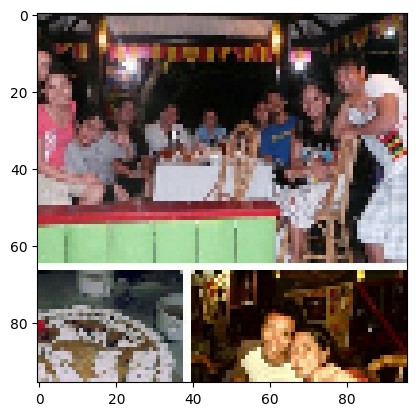

In [88]:
image = geometric_augmentation(image1, 96, (0.4, 1))
image = tf.cast(image, tf.uint8)
plt.imshow(image.numpy())

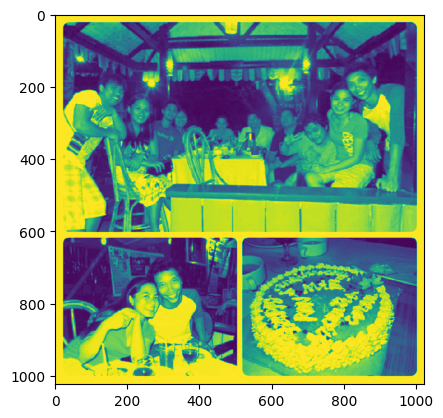

In [181]:
image = color_transform(image1)
plt.imshow(image.numpy())

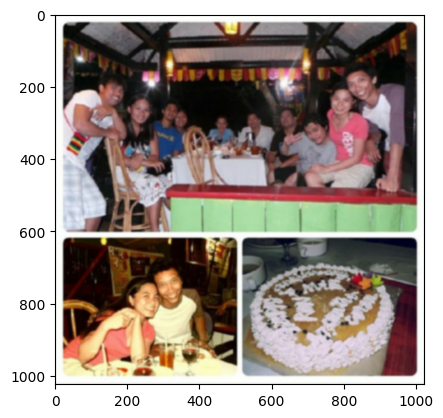

In [20]:
image = gaussian_filter(image1, 0.2)
plt.imshow(image.numpy())

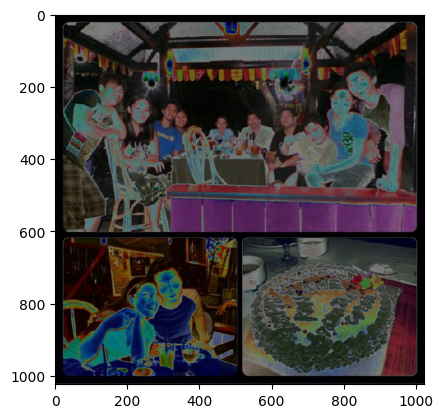

In [23]:
image = random_solarize(image1)
plt.imshow(image.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


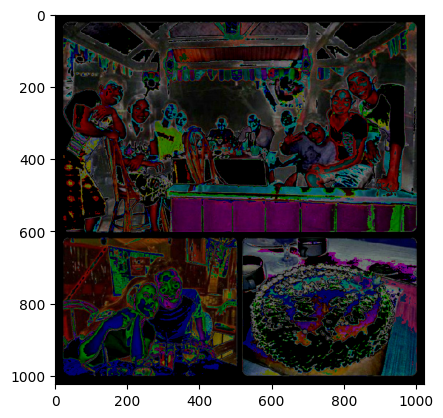

In [32]:
image = normalize(tf.cast(image1, dtype=tf.float32))
plt.imshow(tf.cast(image, dtype=tf.int8).numpy())

In [38]:
image_dataset = paths_dataset.map(lambda x: dino_augmentation(tf.image.convert_image_dtype(tf.io.decode_image(tf.io.read_file(x), expand_animations=False, channels=3), dtype=tf.float32)))

In [39]:
batch_image_dataset = image_dataset.batch(64) # мб не 64...

# Losses

Implement the losses and loss additions. DINO, koleo, sinkhorn_knopp, softmax_centering.

## DINO

In [ ]:
class DinoLoss(tf.keras.losses.Loss):
    def __init__(
            self,
            ncrops,
            warmup_teacher_temp,
            teacher_temp,
            warmup_teacher_temp_epochs,
            nepochs,
            student_temp=0.1,
            center_momentum=0.9
        ) -> None:
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops

        self.teacher_temp_schedule = tf.concat(
            (
                tf.linspace(warmup_teacher_temp, teacher_temp, warmup_teacher_temp_epochs),
                tf.ones((nepochs - warmup_teacher_temp_epochs)) * teacher_temp,
            ),
            axis=0,
        )


    def update_center(self, teacher_output) -> None:
        '''
        Update center used for teacher output.
        
        In article pseudocode -> C = m * C + (1-m) * cat([t1, t2]).mean(dim=0)
        '''

        batch_center = tf.math.reduce_sum(teacher_output, axis=0)
        batch_center = batch_center / tf.cast(len(teacher_output), tf.float32)
        
        self.center = tf.stop_gradient(self.center * self.center_momentum
                                       + batch_center * (1 - self.center_momentum))
        

    def softmax_center_teacher(self, teacher_output, teacher_temp):
        '''
        Center + sharpen for teacher

        In article pseudocode -> t = softmax((t - C) / tpt, dim=1)
        '''
        
        teacher_out = tf.stop_gradient(
            tf.nn.softmax((teacher_output - self.center) / teacher_temp, axis=-1)
        )
        
        return teacher_out
    

    def sinkhorn_knopp_teacher(self, teacher_output, teacher_temp, n_iterations=3):
        '''
        Sinkhorn-Knopp centering https://arxiv.org/pdf/2006.09882.pdf (14 page)
        '''

        Q = tf.transpose(tf.math.exp(teacher_output / teacher_temp))
        Q /= tf.reduce_sum(Q)
        K, B = Q.shape

        for _ in range(n_iterations):
            Q /= tf.reduce_sum(Q, axis=1)
            Q /= K

            Q /= tf.reduce_sum(Q, axis=0)
            Q /= B

        Q *= B

        return tf.transpose(Q)


    def forward(self, student_output, teacher_output, epoch, centering='softmax_center'):
        '''
        Cross-entropy between softmax outputs of the teacher and student networks.
        '''
        
        total_loss = 0

        teacher_output = tf.cast(teacher_output, tf.float32)
        student_output = tf.cast(student_output, tf.float32)

        student_out = student_output / self.student_temp
        student_out = tf.split(student_out, num_or_size_splits=self.ncrops)

        # teacher centering and sharpening
        self.center = tf.zeros_like(teacher_output, dtype=tf.float32)
        
        if centering == 'softmax_center':
            teacher_out = self.softmax_center_teacher(teacher_out, self.teacher_temp_schedule[epoch])
        elif centering == 'sinkhorn_knopp':
            teacher_out = self.sinkhorn_knopp_teacher(teacher_out, self.teacher_temp_schedule[epoch])
        else:
            raise ValueError('Wrang centering algorithm')
        
        teacher_out = tf.split(
            tf.tile(teacher_out, tf.constant([2, 1], tf.int32)), num_or_size_splits=1
        )

        total_loss = 0
        n_loss_terms = 0

        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                q = tf.stop_gradient(q)
                
                if v == iq:
                    # skip cases where student and teacher operate on the same view
                    continue
                
                loss = tf.reduce_sum(-q * tf.nn.log_softmax(student_out[v], axis=-1), axis=-1)
                total_loss += tf.math.reduce_mean(loss)
                n_loss_terms += 1
        
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        
        return total_loss


## KoLeo

In [ ]:
# Kozachenko-Leonenko entropic loss regularizer from Sablayrolles et al. - 2018 - Spreading vectors for similarity search
# Article -> https://arxiv.org/pdf/1806.03198.pdf

class KoLeoLoss(tf.keras.losses.Loss):
    
    def __init__(self) -> None:
        super().__init__()

    
    def pairwise_NNs_inner(self, x):
        dots = tf.linalg.matmul(x, tf.transpose(x))
        n = x.shape[0]

        dots = tf.linalg.set_diag(dots, np.array([-1] * n))

        return tf.math.argmax(dots, 1)
        

    def forward(self, student_output, eps=1e-8): 
        student_output = tf.nn.l2_normalize(student_output, axis=1, epsilon=eps)
        idx = self.pairwise_NNs_inner(student_output)

        distances = tf.norm(student_output - student_output[idx], ord='euclidean')
         
        return -tf.math.reduce_mean(tf.math.log(distances + eps))


# Backbone

Implement transofmer model as described in DINO, including the DINO head. Don't forget the teacher weights update.

Since we will not be training the backbone, extract features from your dataset.

Run the backbone on the images and save the extracted features. Don't forget to process the images. Images don't have to be of the same size, though it would be faster if they were. If the images don't fit in memory, lazily load them from disk

Split your data (extracted features and labels) into train and test subsets.

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [ ]:
train_X = tf.data.Dataset.from_tensor_slices(X_train)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_X, train_y)).batch(128)

test_X = tf.data.Dataset.from_tensor_slices(X_test)
test_y = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_X, test_y)).batch(128)

# Training

Train the model as described in DINO.

# Evaluation

Show that features extracted by your model are similar for similar images and different for others.

# Bonus

Train a simple classification model on top of your extracted features on some simple dataset.